# Music Recommendation System
In this notebook, I create a full recommendation system using TensorFlow. This includes an interface to query the recommendation system.

This notebook will be broken down into the following sections:
1. Data Import
2. Data Processing
3. Data Analysis
4. Saving and RCheckPoint
5. Model Development
6. Model Recommendations
7. Model Embeddings Inspections
8. Model Regularization
5. Deep Learning Model
6. Conclusion

## Setup Environment and Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# Basic
import pandas as pd
import numpy as np

# Visual
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import altair as alt

# Math for mean, mode aggregation
from statistics import *

from datetime import datetime as dt
from IPython import display
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
import collections

tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.float_format = "{:.3f}".format


def mask(df, key, function):
    """Returns a filtered dataframe, by applying function to key"""
    return df[function(df[key])]


def flatten_cols(df):
    df.columns = [" ".join(col).strip() for col in df.columns.values]
    return df


pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
import altair as alt

#alt.data_transformers.enable("default", max_rows=None)
# alt.renderers.enable('colab')

# Install spreadsheets and import authentication module.
# USER_RATINGS = False
#!pip install --upgrade -q gspread
# from google.colab import auth
# import gspread
# from oauth2client.client import GoogleCredentials


Instructions for updating:
non-resource variables are not supported in the long term


## Data Import and Preview
The details for each dataframe have been taken from the readme.txt file

PEP8 style guide is used for naming columns

### Artists
- 17632 artists
- The URL links to the artist page on lastfm. However, the PictureURL doesn't work on google

In [3]:
artist_cols = ["ArtistId", "Name", "URL", "PictureURL"]
df_artists = pd.read_csv(
    "../data/hetrec2011-lastfm-2k/artists.dat",
    sep="\t",
    skiprows=1,
    names=artist_cols,
)
print(df_artists.head())
print(df_artists.info())
print(df_artists.describe(include="object"))


   ArtistId               Name                                         URL  \
0         1       MALICE MIZER       http://www.last.fm/music/MALICE+MIZER   
1         2    Diary of Dreams    http://www.last.fm/music/Diary+of+Dreams   
2         3  Carpathian Forest  http://www.last.fm/music/Carpathian+Forest   
3         4       Moi dix Mois       http://www.last.fm/music/Moi+dix+Mois   
4         5        Bella Morte        http://www.last.fm/music/Bella+Morte   

                                          PictureURL  
0    http://userserve-ak.last.fm/serve/252/10808.jpg  
1  http://userserve-ak.last.fm/serve/252/3052066.jpg  
2  http://userserve-ak.last.fm/serve/252/40222717...  
3  http://userserve-ak.last.fm/serve/252/54697835...  
4  http://userserve-ak.last.fm/serve/252/14789013...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ArtistId

### Tags
- 11946 tags

In [4]:
tags_cols = ["TagId", "Name"]
df_tags = pd.read_csv(
    "../data/hetrec2011-lastfm-2k/tags.dat",
    sep="\t",
    skiprows=1,
    names=tags_cols,
    encoding="latin-1",
)
print(df_tags.head())
print(df_tags.info())
print(df_tags.describe())
print(df_tags.describe(include=['object']))


   TagId               Name
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TagId   11946 non-null  int64 
 1   Name    11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB
None
          TagId
count 11946.000
mean   6242.315
std    3667.498
min       1.000
25%    3036.250
50%    6210.500
75%    9460.750
max   12648.000
         Name
count   11946
unique  11946
top     metal
freq        1


### User Artist
This is name df_user_artist because each row is one user and artist, when artists are aggregated it will be ```df_user_artists```
- 1892 users
- 92834 user-listened artist relations, i.e. tuples [user, artist, listeningCount]
- avg. 49.067 artists most listened by each user
- avg. 5.265 users who listened each artist
- ListenTime is the listening count between UserId and ArtistId ranging from 1 to 352698.

In [5]:
user_artist_cols = ["UserId", "ArtistId", "ListenTime"]
df_user_artist = pd.read_csv(
    "../data/hetrec2011-lastfm-2k/user_artists.dat",
    sep="\t",
    skiprows=1,
    encoding="latin-1",
    names=user_artist_cols,
)
print(df_user_artist.head())
print(df_user_artist.info())
print(df_user_artist.describe())


   UserId  ArtistId  ListenTime
0       2        51       13883
1       2        52       11690
2       2        53       11351
3       2        54       10300
4       2        55        8983
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   UserId      92834 non-null  int64
 1   ArtistId    92834 non-null  int64
 2   ListenTime  92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB
None
         UserId  ArtistId  ListenTime
count 92834.000 92834.000   92834.000
mean   1037.010  3331.123     745.244
std     610.870  4383.591    3751.322
min       2.000     1.000       1.000
25%     502.000   436.000     107.000
50%    1029.000  1246.000     260.000
75%    1568.000  4350.000     614.000
max    2100.000 18745.000  352698.000


### User Friends
- 12717 bi-directional user friend relations, i.e. 25434 (user_i, user_j) pairs
  - avg. 13.443 friend relations per user

In [6]:
user_friends_cols = ["UserId", "FriendId"]
df_user_friends = pd.read_csv(
    "../data/hetrec2011-lastfm-2k/user_friends.dat",
    sep="\t",
    skiprows=1,
    names=user_friends_cols,
)
print(df_user_friends.head())
print(df_user_friends.info())
print(df_user_friends.describe())


   UserId  FriendId
0       2       275
1       2       428
2       2       515
3       2       761
4       2       831
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25434 entries, 0 to 25433
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   UserId    25434 non-null  int64
 1   FriendId  25434 non-null  int64
dtypes: int64(2)
memory usage: 397.5 KB
None
         UserId  FriendId
count 25434.000 25434.000
mean    992.161   992.161
std     603.959   603.959
min       2.000     2.000
25%     441.000   441.000
50%     984.000   984.000
75%    1514.000  1514.000
max    2100.000  2100.000


### Tag Timestamps
- 186479 tag assignments (tas), i.e. tuples [user, tag, artist]
    - avg. 98.562 tas per user
    - avg. 14.891 tas per artist
    - avg. 18.930 distinct tags used by each user
    - avg. 8.764 distinct tags used for each artist

In [7]:
tag_timestamps_cols = ["UserId", "ArtistId", "TagId", "Timestamp"]
df_tag_timestamps = pd.read_csv(
    "../data/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat",
    skiprows=1,
    sep="\t",
    names=tag_timestamps_cols,
)
print(df_tag_timestamps.head())
print(df_tag_timestamps.info())
print(df_tag_timestamps.describe())


   UserId  ArtistId  TagId      Timestamp
0       2        52     13  1238536800000
1       2        52     15  1238536800000
2       2        52     18  1238536800000
3       2        52     21  1238536800000
4       2        52     41  1238536800000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186479 entries, 0 to 186478
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   UserId     186479 non-null  int64
 1   ArtistId   186479 non-null  int64
 2   TagId      186479 non-null  int64
 3   Timestamp  186479 non-null  int64
dtypes: int64(4)
memory usage: 5.7 MB
None
          UserId   ArtistId      TagId         Timestamp
count 186479.000 186479.000 186479.000        186479.000
mean    1035.600   4375.845   1439.583 1239203752024.526
std      622.461   4897.790   2775.340   42990907480.000
min        2.000      1.000      1.000 -428720400000.000
25%      488.000    686.000     79.000 1209592800000.000
50%     1021.000   

### Tag

In [8]:
tag_cols = ["UserId", "ArtistId", "TagId", "Day", "Month", "Year"]
df_tag = pd.read_csv(
    "../data/hetrec2011-lastfm-2k/user_taggedartists.dat",
    sep="\t",
    skiprows=1,
    names=tag_cols,
)
print(df_tag.head())
print(df_tag.info())
print(df_tag.describe())


   UserId  ArtistId  TagId  Day  Month  Year
0       2        52     13    1      4  2009
1       2        52     15    1      4  2009
2       2        52     18    1      4  2009
3       2        52     21    1      4  2009
4       2        52     41    1      4  2009
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186479 entries, 0 to 186478
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   UserId    186479 non-null  int64
 1   ArtistId  186479 non-null  int64
 2   TagId     186479 non-null  int64
 3   Day       186479 non-null  int64
 4   Month     186479 non-null  int64
 5   Year      186479 non-null  int64
dtypes: int64(6)
memory usage: 8.5 MB
None
          UserId   ArtistId      TagId        Day      Month       Year
count 186479.000 186479.000 186479.000 186479.000 186479.000 186479.000
mean    1035.600   4375.845   1439.583      1.096      6.524   2008.810
std      622.461   4897.790   2775.340      0.713      3.

## Data Processing

### Steps to Take
- Drop columns in df_artist
- Create ```dict_artists```, a dictionary for artist id and name.
- Map Artist id to name in ```df_user_artist```
- Merge ```df_tag``` and ```df_tag_timestamps``` on UserId, ArtistId, TagId.
- Convert Tag values to CamelCase.
- Create ```dict_tags```, a dictionary for tag id and name.
- Create a Datetime column from Timestamp.
- Create ```Tag``` column in ```df_tag```.
- Drop rows and artists in ```df_tag``` that contain ```ArtistId``` not in df_user_artist
- Drop rows and tags in ```df_tag``` used only once or twice.
- Create a ```TopTag and AllTags``` column in df_artists for the most popular associated tag and list of all tags
- Create a ```TopTag and AllTags``` column in df_user_artist for the most popular associated tag and list of all tags
- Fill in null tag columns with ```''``` or ```[]``` for ```TopTag``` and ```AllTags```, respectively.
- Indexes need to be changed for ```df_user_artist, df_artists, df_tag```
- Create a one-hot encoding for the tag values.
- Merge one-hot encoding with ```df_tag``` so each row represents each instance of a user applying tags to an artist. 
- Create a relationship measure for friends based on their shared artist listens

#### Drop URL rows

In [9]:
# These will not be used
df_artists.drop(['URL', 'PictureURL'], axis=1, inplace=True)

#### Map Artist Name
Created a dictionary to use only for mapping the id in df_user_artist to a name for easier analysis

In [10]:
dict_artists = dict(zip(df_artists["ArtistId"], df_artists["Name"]))
df_user_artist['Name'] = df_user_artist.ArtistId.map(dict_artists)

#### Tag Wrangling

In [11]:
df_tag = df_tag.merge(
    df_tag_timestamps, 
    on=["UserId", "ArtistId", "TagId"],
)
del df_tag_timestamps


In [12]:
def CamelCase(s):
    '''CamelCase converts a string "hello world" to CamelCase "HelloWorld"'''
    return "".join([s.capitalize() for s in s.split()])

df_tags.Name = df_tags.Name.transform(CamelCase)
dict_tags = dict(zip(df_tags["TagId"], df_tags["Name"]))

In [13]:
# Creating Tag column with name mapped from tag id
df_tag["Tag"] = df_tag.TagId.map(dict_tags)


In [14]:
# Timestamp is too big and needs to be scaled first
df_tag["Timestamp"] = df_tag.Timestamp / 1e3
df_tag["Datetime"] = pd.to_datetime(df_tag["Timestamp"], unit="s")


In [15]:
# removing artists that have not been listened to, these will be not be used in analysis
before = df_tag.shape[0]
before_artists = df_tag.ArtistId.nunique()
df_tag = df_tag.loc[df_tag.ArtistId.isin(df_user_artist.ArtistId)]
after = df_tag.shape[0]
after_artists = df_tag.ArtistId.nunique()

In [16]:
print(f'''
{before - after } rows were dropped.
{before_artists - after_artists} artists were removed.
''')


1538 rows were dropped.
390 artists were removed.



In [17]:
# Removing tags that are only used once or twice. Threshold is set at 2 due to the large drop from 2 to 3 tag uses
# There are many tags used only once or twice but they are not very useful for understanding the artist
before = df_tag.shape[0]
before_tags = df_tag.TagId.nunique()
tag_frequency = df_tag.groupby('TagId')['UserId'].count().sort_values()
frequent_tags = tag_frequency[tag_frequency > 2]
df_tag = df_tag.loc[df_tag.TagId.isin(frequent_tags)]
after = df_tag.shape[0]
after_tags = df_tag.TagId.nunique()

In [18]:
print(f'''
{before - after} rows have been dropped.
{before_tags - after_tags} tags have been removed.
''')


97870 rows have been dropped.
9471 tags have been removed.



#### Merge Tags, Users and Artists

- Below are the tags grouped by user and artist. When merged with user artist dataframe there are many null values.
- Users only tag a proportion of the artists they listen to.

In [19]:
df_tag.groupby(
    ['UserId', "ArtistId"]
).agg(
    TopTag = ('Tag', mode), 
    AllTags = ('Tag', list)
).reset_index().sort_values(['UserId', 'ArtistId']).head(5)

,UserId,ArtistId,TopTag,AllTags
0,2,52,Chillout,"[Chillout, Downtempo, Electronic, Trip-hop, Fe..."
1,2,63,Chillout,"[Chillout, Ambient, NewAge, GregorianChant]"
2,2,73,Chillout,"[Chillout, Ambient, Downtempo, Electronic, Lou..."
3,2,94,Chillout,"[Chillout, Downtempo, Lounge, Trip-hop, AcidJa..."
4,2,96,80's,"[80's, Pop]"


In [20]:
df_user_artist.merge(
    df_tag.loc[
        df_tag.ArtistId.isin(df_user_artist.ArtistId)
    ].groupby(
        ['UserId', "ArtistId"]
    ).agg(
        TopTag = ('Tag', mode), 
        AllTags = ('Tag', list)
    ).reset_index().sort_values(['UserId', 'ArtistId']),
    left_on=['UserId', "ArtistId"],
    right_on=['UserId', "ArtistId"],
    how='left').head(5)

,UserId,ArtistId,ListenTime,Name,TopTag,AllTags
0,2,51,13883,Duran Duran,NaN,NaN
1,2,52,11690,Morcheeba,Chillout,"[Chillout, Downtempo, Electronic, Trip-hop, Fe..."
2,2,53,11351,Air,NaN,NaN
3,2,54,10300,Hooverphonic,NaN,NaN
4,2,55,8983,Kylie Minogue,NaN,NaN


In [21]:
df_artists = df_artists.merge(
    df_tag.groupby("ArtistId").agg(TopTag = ('Tag', mode), AllTags = ('Tag', list)),
    left_on='ArtistId',
    right_index=True,
    how='left'
)


In [22]:
# TotalListenTime, MeanListenTime and FanCount are different measures used to understand the artists
df_artists = df_artists.merge(
    df_user_artist.groupby("ArtistId").agg(
        TotalListenTime=("ListenTime", sum),
        MeanListenTime=("ListenTime", mean),
        FanCount=("ListenTime", len),
    ),
    left_on='ArtistId',
    right_index=True
)


In [23]:
# Replacing null values is very important when implementing softmax model
for row in df_artists.loc[df_artists.TopTag.isnull(), 'TopTag'].index:
    df_artists.at[row, 'TopTag'] = ''
    df_artists.at[row, 'AllTags'] = []

In [24]:
df_artists.head()

,ArtistId,Name,TopTag,AllTags,TotalListenTime,MeanListenTime,FanCount
0,1,MALICE MIZER,VisualKei,"[VisualKei, VisualKei, VisualKei]",771,257.000,3
1,2,Diary of Dreams,German,"[German, SeenLive, Industrial, German, German,...",8012,667.667,12
2,3,Carpathian Forest,BlackMetal,"[BlackMetal, BlackMetal, BlackMetal]",775,258.333,3
3,4,Moi dix Mois,VisualKei,"[VisualKei, Rock, VisualKei, GothicMetal, Visu...",563,281.500,2
4,5,Bella Morte,GothicRock,[GothicRock],913,456.500,2


In [25]:
df_user_artist = df_user_artist.merge(
    df_tag.groupby(['UserId', "ArtistId"]).agg(TopTag = ('Tag', mode), AllTags = ('Tag', list)).reset_index(),
    left_on=['UserId', "ArtistId"],
    right_on=['UserId', "ArtistId"],
    how='left'
)

In [26]:
# Replacing null values is very important when implementing softmax model
for row in df_user_artist.loc[df_user_artist.TopTag.isnull(), 'TopTag'].index:
    df_user_artist.at[row, 'TopTag'] = ''
    df_user_artist.at[row, 'AllTags'] = []

In [27]:
df_user_artist.head()

,UserId,ArtistId,ListenTime,Name,TopTag,AllTags
0,2,51,13883,Duran Duran,,[]
1,2,52,11690,Morcheeba,Chillout,"[Chillout, Downtempo, Electronic, Trip-hop, Fe..."
2,2,53,11351,Air,,[]
3,2,54,10300,Hooverphonic,,[]
4,2,55,8983,Kylie Minogue,,[]


#### Resetting Indexes

In [28]:
# Creating user index dictionary
users = df_user_artist.UserId.sort_values().unique()
idx_users = range(len(users))
dict_idx_users = dict(zip(users, idx_users))

# Creating artist index dictionary
artists = df_artists.ArtistId.sort_values().unique()
idx_artists = range(len(artists))
dict_idx_artists = dict(zip(artists, idx_artists))

In [29]:
# Mapping UserId index to new index
df_user_artist["UserId"] = df_user_artist.UserId.map(dict_idx_users).astype('str')
df_user_friends["UserId"] = df_user_friends.UserId.map(dict_idx_users).astype('str')
df_user_friends["FriendId"] = df_user_friends.FriendId.map(dict_idx_users).astype('str')
df_tag["UserId"] = df_tag.UserId.map(dict_idx_users).astype('str')

# Mapping ArtistId index to new index
df_user_artist["ArtistId"] = df_user_artist.ArtistId.map(dict_idx_artists).astype('str')
df_tag["ArtistId"] = df_tag.ArtistId.map(dict_idx_artists).astype('str')
df_artists['ArtistId'] = df_artists.ArtistId.map(dict_idx_artists).astype('str')


#### Creating Grouped Tag dataframe based on Datetime

In [30]:
df_tag_grouped_datetime = (
    pd.get_dummies(
        df_tag.set_index(["UserId", "ArtistId", "Datetime"])["Tag"]
    )
    .groupby(["UserId", "ArtistId", "Datetime"])
    .apply(sum, axis=0)
)


df_tag_grouped_datetime["Tags"] = df_tag.groupby(["UserId", "ArtistId", "Datetime"])[
    "Tag"
].apply(list)


In [31]:
df_tag_grouped_datetime.head()

00s  1900  1985  60's  80's  80s  \
UserId ArtistId Datetime                                                
0      3818     2009-04-30 22:00:00    0     0     0     0     0    0   
       46       2009-03-31 22:00:00    0     0     0     0     0    0   
       57       2009-03-31 22:00:00    0     0     0     0     0    0   
       6035     2009-04-30 22:00:00    0     0     0     0     0    0   
       6052     2009-04-30 22:00:00    0     0     0     0     0    0   

                                     80sGarage  80sPop  Abstract  AcidJazz  \
UserId ArtistId Datetime                                                     
0      3818     2009-04-30 22:00:00          0       0         0         0   
       46       2009-03-31 22:00:00          0       0         0         0   
       57       2009-03-31 22:00:00          0       0         0         0   
       6035     2009-04-30 22:00:00          0       0         0         0   
       6052     2009-04-30 22:00:00          0       0         0         0   

                                     ...  Vu-us  Want  WantToSeeLive  \
UserId ArtistId Datetime             ...                               
0      3818     2009-04-30 22:00:00  ...      0     0              0   
       46       2009-03-31 22:00:00  ...      0     0              0   
       57       2009-03-31 22:00:00  ...      0     0              0   
       6035     2009-04-30 22:00:00  ...      0     0              0   
       6052     2009-04-30 22:00:00  ...      0     0              0   

                                     WarMetal  WarpedTour  WhitesnakeCover  \
UserId ArtistId Datetime                                                     
0      3818     2009-04-30 22:00:00         0           0                0   
       46       2009-03-31 22:00:00         0           0                0   
       57       2009-03-31 22:00:00         0           0                0   
       6035     2009-04-30 22:00:00         0           0                0   
       6052     2009-04-30 22:00:00         0           0                0   

                                     Winter  World  WorldMusic  \
UserId ArtistId Datetime                                         
0      3818     2009-04-30 22:00:00       0      0           0   
       46       2009-03-31 22:00:00       0      0           0   
       57       2009-03-31 22:00:00       0      0           0   
       6035     2009-04-30 22:00:00       0      0           0   
       6052     2009-04-30 22:00:00       0      0           0   

                                                                                  Tags  
UserId ArtistId Datetime                                                                
0      3818     2009-04-30 22:00:00               [NewWave, Avant-garde, Experimental]  
       46       2009-03-31 22:00:00  [Chillout, Downtempo, Electronic, Trip-hop, Fe...  
       57       2009-03-31 22:00:00        [Chillout, Ambient, NewAge, GregorianChant]  
       6035     2009-04-30 22:00:00                                 [Ambient, Minimal]  
       6052     2009-04-30 22:00:00  [Chillout, Ambient, Downtempo, Lounge, CafeDel...  

[5 rows x 248 columns]

## Data Analysis
Data Analysis always begins with questions to answer.

### Questions
1. What is the distribution of ListenTime
1. How many artists do users tags on average?
2. How many distinct times does a user tag the same artist on average? 
3. Are the tags the same or different each time?

### Concerns
- How is it possible to have a friendship that is not bi-directional?
- How are friendships developed?

#### What is the distribution of ListenTime for each user and Artist?
- ListenTime has a very long right tail
- Users have spent 36566.583 minutes listening to music on average with standard deviation 48744.552.
- Artists have been listened to for 3923.774 minutes on average with standard deviation 34099.342.
- Each user listens to more music than each artist is listened to

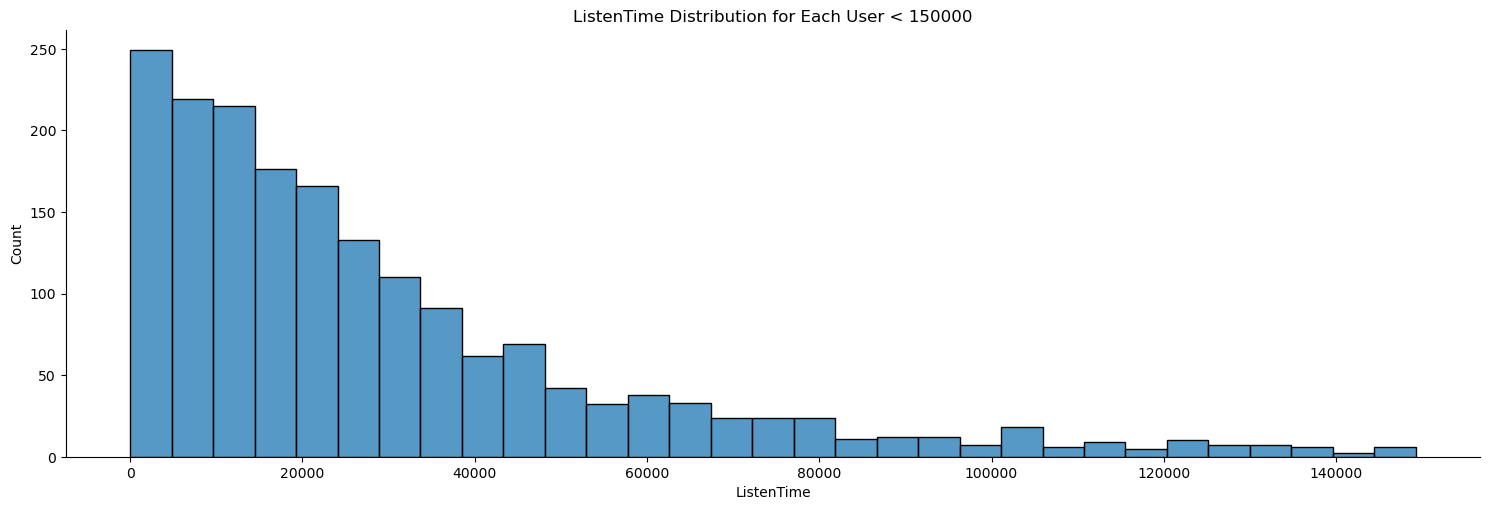

In [32]:
sns.displot(
    data=df_user_artist.groupby(
        'UserId',as_index=False
    )['ListenTime'].sum().query('ListenTime < 150000'), 
    x='ListenTime', 
    aspect=3
)
plt.title('ListenTime Distribution for Each User < 150000');

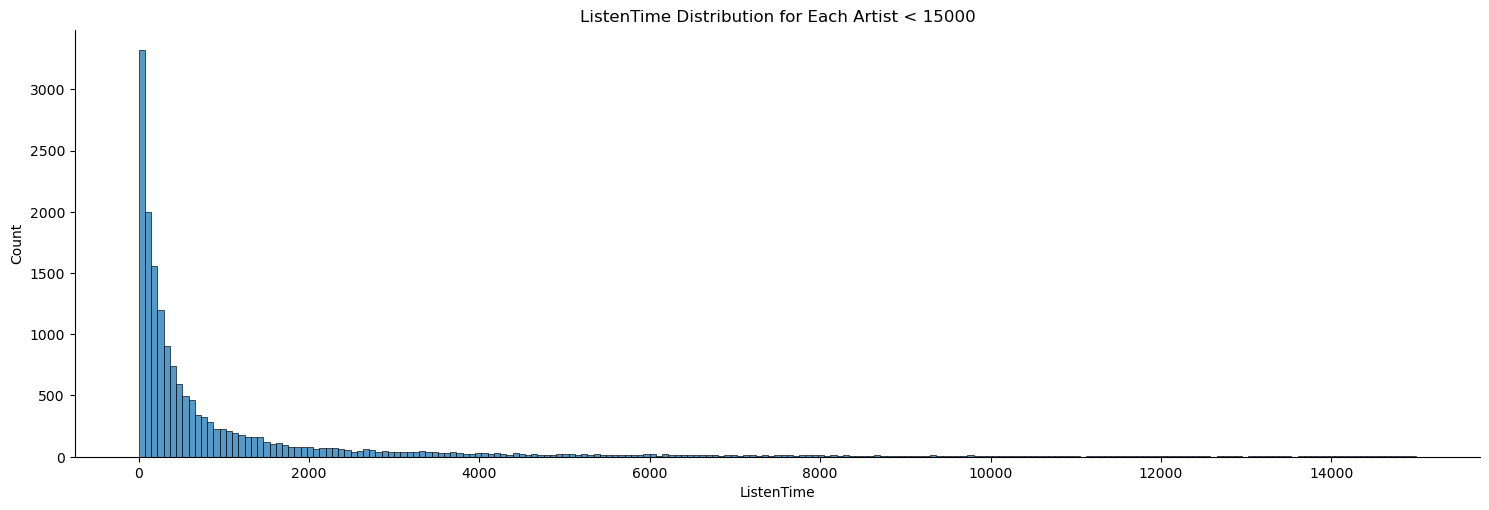

In [33]:
sns.displot(
    data=df_user_artist.groupby(
        'ArtistId',as_index=False
    )['ListenTime'].sum().query('ListenTime < 15000'), 
    x='ListenTime', 
    aspect=3
)
plt.title('ListenTime Distribution for Each Artist < 15000');

In [34]:
listen_mean_user = df_user_artist.groupby(
    'UserId'
)['ListenTime'].sum().mean().round(3)
listen_std_user = round(df_user_artist.groupby(
    'UserId'
)['ListenTime'].sum().std(), 3)
listen_mean_artist = df_user_artist.groupby(
    'ArtistId'
)['ListenTime'].sum().mean().round(3)
listen_std_artist = round(df_user_artist.groupby(
    'ArtistId'
)['ListenTime'].sum().std(), 3)

In [35]:
print(f'''
- Users have spent {listen_mean_user} minutes listening to music on average with standard deviation {listen_std_user}.
- Artists have been listened to for {listen_mean_artist} minutes on average with standard deviation {listen_std_artist}.
''')


- Users have spent 36566.583 minutes listening to music on average with standard deviation 48744.552.
- Artists have been listened to for 3923.774 minutes on average with standard deviation 34099.342.



#### How many distinct artists do users tags on average?
- Each users applies a tag to 27.625 artists on average.
- There is a large standard deviation of 63.435.
- 370 users tag 1 artist.
- 1 user tags 794 artists.

In [36]:
user_artist_counts = (
    df_tag_grouped_datetime.groupby(["UserId", "ArtistId"])["Tags"].first().groupby("UserId").count()
)


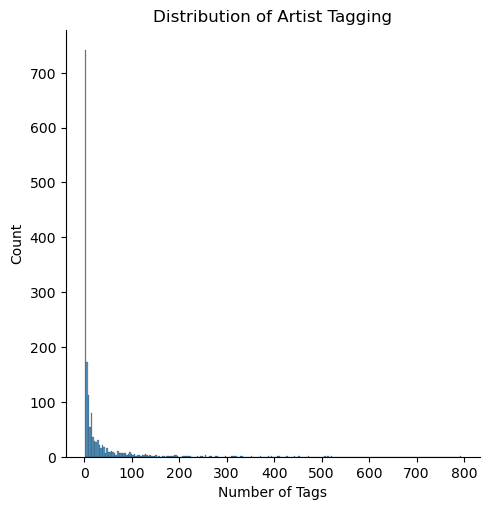

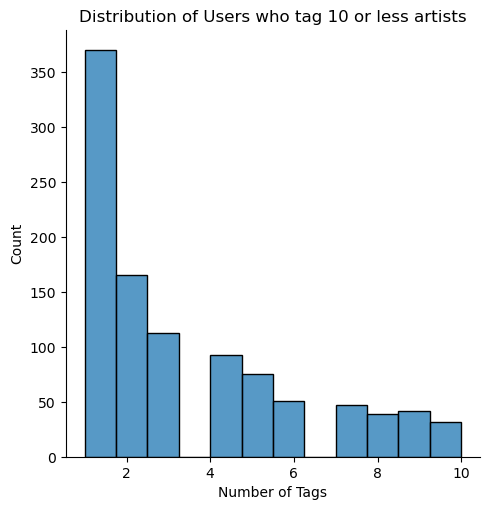

In [37]:
sns.displot(user_artist_counts).set(
    title="Distribution of Artist Tagging", xlabel="Number of Tags"
)
sns.displot(user_artist_counts[user_artist_counts <= 10]).set(
    title="Distribution of Users who tag 10 or less artists", xlabel="Number of Tags"
)


In [38]:
print(
    f"""
- Each users applies a tag to {user_artist_counts.mean().round(3)} artists on average.
- There is a large standard deviation of {round(user_artist_counts.std(), 3)}.
- {user_artist_counts.value_counts()[1]} users tag 1 artist.
- 1 user tags {user_artist_counts.max()} artists.
"""
)



- Each users applies a tag to 27.625 artists on average.
- There is a large standard deviation of 63.435.
- 370 users tag 1 artist.
- 1 user tags 794 artists.



#### How many distinct times does a user apply a set of tags to the same artist on average? 
- A user tags the same artist 1.126 times on average.
- Standard deviation is 0.44.
- 40469 users have tagged an artist only one time.
- 1 user tagged an artist 13 times.

In [39]:
user_artist_repeats = df_tag_grouped_datetime.groupby(["UserId", "ArtistId"])["Tags"].count()


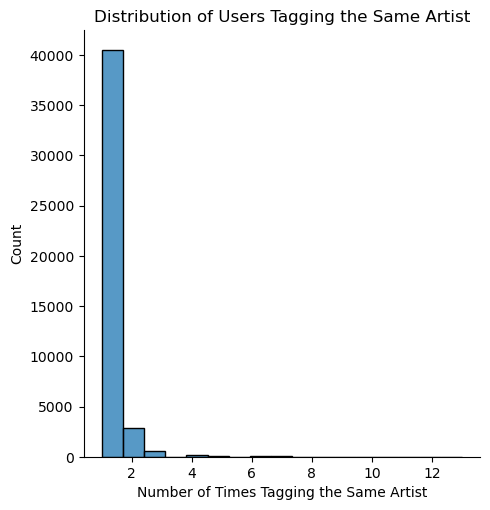

In [40]:
sns.displot(user_artist_repeats).set(
    title="Distribution of Users Tagging the Same Artist",
    xlabel="Number of Times Tagging the Same Artist",
)


In [41]:
print(
    f"""
- A user tags the same artist {user_artist_repeats.groupby('UserId').mean().mean().round(3)} times on average.
- Standard deviation is {round(user_artist_repeats.groupby('UserId').mean().std(), 3)}.
- {user_artist_repeats.value_counts()[1]} users have tagged an artist only one time.
- 1 user tagged an artist {user_artist_repeats.max()} times.
"""
)



- A user tags the same artist 1.126 times on average.
- Standard deviation is 0.44.
- 40469 users have tagged an artist only one time.
- 1 user tagged an artist 13 times.



#### Are the tags the same or different each time?
- Every time a users adds more tags, they are different from the tags previously applied to that artist.

For this question, I will make a list called ```repeat_tag_users``` of all (Users Artists) pairs where the user has applied a set of tags to an artist more than once.

I will then create ```df_tag_grouped_artist``` dataframe of only users who applied a set of tags to an artist more than once. Each row will represent a ```(UserId, ArtistId)``` pair. There will be a column of all tags a user applied to an artist and a column containing a distinct set of these tags. Using these columns, a percentage of distinct/duplicate tags will be calculated.

In [42]:
repeat_tag_users = user_artist_repeats[user_artist_repeats > 1].reset_index()[
    ["UserId", "ArtistId"]
]


In [43]:
# Creating indexes for filtering dataframes
index1 = pd.MultiIndex.from_arrays(
    [repeat_tag_users[col] for col in ["UserId", "ArtistId"]]
)
index2 = pd.MultiIndex.from_arrays(
    [df_tag[col] for col in ["UserId", "ArtistId"]]
)


In [44]:
df_tag_grouped_artist = (
    df_tag.loc[index2.isin(index1)]
    .groupby(["UserId", "ArtistId"])
    .agg(AllTags=("Tag", list), UniqueTags=("Tag", set))
    .reset_index()
)


In [45]:
df_tag_grouped_artist["TotalCount"] = df_tag_grouped_artist.AllTags.transform(len)
df_tag_grouped_artist["UniqueCount"] = df_tag_grouped_artist.UniqueTags.transform(len)
df_tag_grouped_artist["DistinctPercentage"] = df_tag_grouped_artist.eval("UniqueCount / TotalCount")


In [46]:
df_tag_grouped_artist.head()


,UserId,ArtistId,AllTags,UniqueTags,TotalCount,UniqueCount,DistinctPercentage
0,1,102,"[Downtempo, Experimental, Melancholy, Idm, Fem...","{Melancholy, Idm, Downtempo, Experimental, Gre...",6,6,1.000
1,1,95,"[Ambient, Downtempo, Experimental, Glitch, U-c...","{Folktronica, Melancholy, Experimental, U-cove...",23,23,1.000
2,1,96,"[Ambient, Downtempo, Electronic, Experimental,...","{Melancholy, Glitch, Electronic, Downtempo, Ex...",8,8,1.000
3,10,1604,"[Hip-hop, Rap]","{Hip-hop, Rap}",2,2,1.000
4,10,327,"[Pop, Rock]","{Rock, Pop}",2,2,1.000


In [47]:
df_tag_grouped_artist[df_tag_grouped_artist.DistinctPercentage < 1]


,UserId,ArtistId,AllTags,UniqueTags,TotalCount,UniqueCount,DistinctPercentage


## Saving Processed Data to Pickle files and re-Importing (Checkpoint)
- This section is used to save the work up to now.
- This acts a checkpoint so when rerunning code, you can used the processed code from here rather than running the rest of the notebook.

In [48]:
path_artists = '../data/processed/artists.pkl'
df_artists.to_pickle(path_artists)

path_user_artist = '../data/processed/user_artist.pkl'
df_user_artist.to_pickle(path_user_artist)

path_tag = '../data/processed/tag.pkl'
df_tag.to_pickle(path_tag)

path_tag_grouped_datetime = '../data/processed/tag_grouped_datetime.pkl'
df_tag_grouped_datetime.to_pickle(path_tag_grouped_datetime)

path_tag_grouped_artist = '../data/processed/tags_grouped_artist.pkl'
df_tag_grouped_artist.to_pickle(path_tag_grouped_artist)

In [49]:
path_user_artist = '../data/processed/user_artist.pkl'
path_tag = '../data/processed/tag.pkl'
path_tag_grouped_datetime = '../data/processed/tag_grouped_datetime.pkl'
path_tag_grouped_artist = '../data/processed/tags_grouped_artist.pkl'
path_artists = '../data/processed/artists.pkl'


In [50]:
df_user_artist = pd.read_pickle(path_user_artist)
df_tag = pd.read_pickle(path_tag)
df_tag_grouped_datetime = pd.read_pickle(path_tag_grouped_datetime)
df_tag_grouped_artist = pd.read_pickle(path_tag_grouped_artist)
df_artists = pd.read_pickle(path_artists)

In [51]:
for df in [df_user_artist, df_tag, df_tag_grouped_datetime, df_tag_grouped_artist, df_artists]:
    print(f'{df.shape}')

(92834, 6)
(87071, 9)
(49556, 248)
(3758, 7)
(17632, 7)


In [52]:
df_artists.head()

,ArtistId,Name,TopTag,AllTags,TotalListenTime,MeanListenTime,FanCount
0,0,MALICE MIZER,VisualKei,"[VisualKei, VisualKei, VisualKei]",771,257.000,3
1,1,Diary of Dreams,German,"[German, SeenLive, Industrial, German, German,...",8012,667.667,12
2,2,Carpathian Forest,BlackMetal,"[BlackMetal, BlackMetal, BlackMetal]",775,258.333,3
3,3,Moi dix Mois,VisualKei,"[VisualKei, Rock, VisualKei, GothicMetal, Visu...",563,281.500,2
4,4,Bella Morte,GothicRock,[GothicRock],913,456.500,2


In [53]:
df_user_artist.head()

,UserId,ArtistId,ListenTime,Name,TopTag,AllTags
0,0,45,13883,Duran Duran,,[]
1,0,46,11690,Morcheeba,Chillout,"[Chillout, Downtempo, Electronic, Trip-hop, Fe..."
2,0,47,11351,Air,,[]
3,0,48,10300,Hooverphonic,,[]
4,0,49,8983,Kylie Minogue,,[]


In [54]:
df_tag.head()

,UserId,ArtistId,TagId,Day,Month,Year,Timestamp,Tag,Datetime
0,0,46,13,1,4,2009,1238536800.000,Chillout,2009-03-31 22:00:00
1,0,46,15,1,4,2009,1238536800.000,Downtempo,2009-03-31 22:00:00
2,0,46,18,1,4,2009,1238536800.000,Electronic,2009-03-31 22:00:00
3,0,46,21,1,4,2009,1238536800.000,Trip-hop,2009-03-31 22:00:00
4,0,46,41,1,4,2009,1238536800.000,FemaleVovalists,2009-03-31 22:00:00


In [55]:
df_tag_grouped_artist.head()

,UserId,ArtistId,AllTags,UniqueTags,TotalCount,UniqueCount,DistinctPercentage
0,1,102,"[Downtempo, Experimental, Melancholy, Idm, Fem...","{Melancholy, Idm, Downtempo, Experimental, Gre...",6,6,1.000
1,1,95,"[Ambient, Downtempo, Experimental, Glitch, U-c...","{Folktronica, Melancholy, Experimental, U-cove...",23,23,1.000
2,1,96,"[Ambient, Downtempo, Electronic, Experimental,...","{Melancholy, Glitch, Electronic, Downtempo, Ex...",8,8,1.000
3,10,1604,"[Hip-hop, Rap]","{Hip-hop, Rap}",2,2,1.000
4,10,327,"[Pop, Rock]","{Rock, Pop}",2,2,1.000


### Create df_user_artists
- This is the data frame used for the softmax deep learning model
- It groups all artists for each user

In [56]:
df_user_artists = (
    df_user_artist[["UserId", "ArtistId"]]
    .groupby("UserId", as_index=False)
    .aggregate(lambda x: list(x))
)

In [57]:
# Since UserId is a string, it is sorted alphanumerically
df_user_artists.head()

,UserId,ArtistId
0,0,"[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5..."
1,1,"[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, ..."
2,10,"[66, 183, 185, 224, 282, 294, 327, 338, 371, 3..."
3,100,"[597, 610, 735, 739, 744, 746, 747, 763, 769, ..."
4,1000,"[49, 50, 58, 59, 61, 65, 83, 251, 282, 283, 28..."


## Model Development Functions

### Split Dataframe

In [58]:
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test


### Build Listen Sparse Tensor

In [59]:
def build_listen_sparse_tensor(df_user_artist, n_users, n_artists):
    """
    Args:
    df_user_artist: a pd.DataFrame with `UserId`, `ArtistId` and `ListenTime` columns.
    Returns:
    a tf.SparseTensor representing the ratings matrix.
    """
    indices = df_user_artist[["UserId", "ArtistId"]].values
    values = df_user_artist["ListenTime"].values
    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[n_users, n_artists],
    )


### Mean Square Error

In [60]:
def sparse_mean_square_error(sparse_listens, user_embeddings, artist_embeddings):
    """
    Args:
    sparse_ratings: A SparseTensor listen matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    artist_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of artist j.
    Returns:
    A scalar Tensor representing the MSE between the true listens and the
      model's predictions.
    """
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_listens.indices[:, 0])
        * tf.gather(artist_embeddings, sparse_listens.indices[:, 1]),
        axis=1,
    )
    loss = tf.losses.mean_squared_error(sparse_listens.values, predictions)
    return loss


###  Collaborative Filtering Model

In [61]:
class CFModel(object):
    """Simple class that represents a collaborative filtering model"""

    def __init__(self, embedding_vars, loss, metrics=None):
        """Initializes a CFModel.
        Args:
          embedding_vars: A dictionary of tf.Variables.
          loss: A float Tensor. The loss to optimize.
          metrics: optional list of dictionaries of Tensors. The metrics in each
            dictionary will be plotted in a separate figure during training.
        """
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        """The embeddings dictionary."""
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
              optimizer=tf.train.GradientDescentOptimizer):
        """Trains the model.
        Args:
          iterations: number of iterations to run.
          learning_rate: optimizer learning rate.
          plot_results: whether to plot the results at the end of training.
          optimizer: the optimizer to use. Default to GradientDescentOptimizer.
        Returns:
          The metrics dictionary evaluated at the last iteration.
        """
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                          end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics) + 1
                fig = plt.figure()
                fig.set_size_inches(num_subplots * 10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i + 1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results

### Build Model

In [62]:
def build_model(df_user_artist, embedding_dim=3, init_stddev=1.0):
    """
    Args:
    df_user_artist: a DataFrame of the listening time for each user artist pair
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
    Returns:
    model: a CFModel.
    """
    # Creating number of users and artists variables
    n_users, n_artists = (
        df_user_artist.UserId.nunique(),
        df_user_artist.ArtistId.nunique(),
    )

    # Split the ratings DataFrame into train and test.
    train_listens, test_listens = split_dataframe(df_user_artist)

    # SparseTensor representation of the train and test datasets.
    A_train = build_listen_sparse_tensor(train_listens, n_users, n_artists)
    A_test = build_listen_sparse_tensor(test_listens, n_users, n_artists)

    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(
        tf.random_normal([A_train.dense_shape[0], embedding_dim], stddev=init_stddev)
    )
    V = tf.Variable(
        tf.random_normal([A_train.dense_shape[1], embedding_dim], stddev=init_stddev)
    )
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {"train_error": train_loss, "test_error": test_loss}
    embeddings = {"UserId": U, "ArtistId": V}
    return CFModel(embeddings, train_loss, [metrics])


## Model Evaluation Functions

### Compute Scores

In [63]:
def compute_scores(query_embedding, item_embeddings, measure="dot"):
    """Computes the scores of the candidates given a query.
    Args:
      query_embedding: a vector of shape [k], representing the query embedding.
      item_embeddings: a matrix of shape [N, k], such that row i is the embedding
        of item i.
      measure: a string specifying the similarity measure to be used. Can be
        either DOT or COSINE.
    Returns:
      scores: a vector of shape [N], such that scores[i] is the score of item i.
    """
    u = query_embedding
    V = item_embeddings
    if measure == "cosine":
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

### User Recommendations

In [64]:
def user_recommendations(model, measure='dot', UserId=0, exclude_rated=False, k=6):
    scores = compute_scores(
        model.embeddings["UserId"][UserId], model.embeddings["ArtistId"], measure
    )
    score_key = measure + " score"
    df = pd.DataFrame(
        {
            score_key: list(scores),
            "ArtistId": df_artists["ArtistId"]
            ,"Name": df_artists["Name"]
            ,'TopTag': df_artists['TopTag']
            ,'AllTags': df_artists['AllTags']
        }
    )

    if exclude_rated:
        # remove artists that are already rated
        rated_artists = ratings[ratings.UserId == "1892"]["ArtistId"].values
        df = df[df.ArtistId.apply(lambda ArtistId: ArtistId not in rated_artists)]
    display.display(df.sort_values([score_key], ascending=False).head(k))



### Artist Neighbors

In [65]:
def artist_neighbors(model, name_substring='Kanye', measure='dot', k=6):
    # Search for artists that match the given substring.
    ids =  df_artists.loc[df_artists['Name'].str.contains(name_substring), 'ArtistId'].astype('int').values
    names = df_artists.Name[ids]
    if len(names) == 0:
        raise ValueError(f"Found no artists with name {name_substring}")
    print(f"Nearest neighbors of : {names.iloc[0]}.")

    if len(names) > 1:
        print(f"Found more than one matching artist. Other candidates: {', '.join(names.iloc[1:])}")
    artist = names.iloc[0]
    scores = compute_scores(
        model.embeddings["ArtistId"][ids[0]], model.embeddings["ArtistId"],
        measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores)
        ,'Name': df_artists['Name']
        ,'TopTag': df_artists['TopTag']
        ,'AllTags': df_artists['AllTags']
    })
    display.display(df.sort_values(score_key, ascending=False).head(k))

### Personalized Recommendations
For personalised recommendations create a dictionary of your favourite artists and estimated total listening time.

For example 
```
{
    'Chris Brown': 4000,
    'Justin Timberlake': 6000,
    'David Guetta': 500,
    'Kanye West': 100,
    'Drake': 200
}
```

In [66]:
def next_user_id():
    '''
    Finds the next user id from df_user_artist for inserting into the dataframe
    '''
    return df_user_artist.UserId.nunique()

In [67]:
def next_index():
    '''
    Finds the next index in df_user_artist for inserting into the dataframe
    '''
    return len(df_user_artist)

In [68]:
# Create dictionary to map name to id for adding preferences
dict_artist_to_id = dict(zip(df_user_artist['Name'], df_user_artist['ArtistId']))

### Add Preferences

In [69]:
def add_preferences(df, preferences):
    '''
    This function allows a user to add their preferences to the dataframe.
    Returns the dataframe df, an updated grouped version of df and the user id my_user_id.

    Arguments:
    df : dataframe that will be appended to. (df_user_artist)
    preferences : a dictionary contain artist and total listening time as (key, value) pairs.
    
    Example:
    preferences = {
        'One Republic': 400
    }
    df, df_grouped, my_user_id = add_preferences(df, preferences)
    '''
    # Setting variable values
    top_tag = ""
    all_tags = []
    my_user_id = str(next_user_id())
    for artist, listen_time in preferences.items():
        # Using a try except to capture invalid names
        try:
            artist_id = str(dict_artist_to_id[artist])
            row = [
                my_user_id,
                artist_id,
                listen_time,
                artist,
                top_tag,
                all_tags,
            ]
            df.loc[next_index()] = row
        except(KeyError):
            print(artist, 'is not in df_user_artist. They will be skipped.')
    
    # Updating the grouped version of df
    df_grouped = (df[["UserId", "ArtistId"]]
    .groupby("UserId", as_index=False)
    .aggregate(lambda x: list(x))
    )
    return df, df_grouped, my_user_id

### Remove Preferences

In [70]:
def remove_preferences(df, my_user_id):
    '''
    This function removes the records for a specified UserId in df.
    Arguments:
    - df : dataframe to be updated.
    - my_user_id : user id to be removed from df.
    '''
    return df.loc[df.UserId != my_user_id]

In [71]:
preferences1 = {
    'Chris Brown': 4000,
    'Justin Timberlake': 6000,
    'David Guetta': 500,
    'Kanye West': 100,
    'Drake': 200
}
preferences2 = {
    'Black Eyed Peas': 1000,
    'Katy Perry': 2050,
    'Jennifer Lopez': 2500,
    'Beyoncé': 3570,
    'Leona Lewis': 2660
}

In [72]:
df_user_artist, df_user_artists, my_user_id1 = add_preferences(df_user_artist, preferences1)

In [73]:
# Below you can see the preferences have been added
df_user_artist.tail()

,UserId,ArtistId,ListenTime,Name,TopTag,AllTags
92834,1892,321,4000,Chris Brown,,[]
92835,1892,323,6000,Justin Timberlake,,[]
92836,1892,322,500,David Guetta,,[]
92837,1892,325,100,Kanye West,,[]
92838,1892,3280,200,Drake,,[]


In [74]:
# If I want to remove those preferences, the output shows how they are now removed
df_user_artist = remove_preferences(df_user_artist, my_user_id1)
df_user_artist.tail()

,UserId,ArtistId,ListenTime,Name,TopTag,AllTags
92829,1891,17615,337,Nyktalgia,,[]
92830,1891,17616,297,Atsakau niekadA,,[]
92831,1891,17617,281,Domantas Razauskas,,[]
92832,1891,17618,280,Atalyja,,[]
92833,1891,17619,263,Les Chants de Nihil,,[]


In [75]:
# Adding them back in along with other preferences
df_user_artist, df_user_artists, my_user_id1 = add_preferences(df_user_artist, preferences1)
df_user_artist, df_user_artists, my_user_id2 = add_preferences(df_user_artist, preferences2)

In [76]:
# Checking my_user_id
my_user_id1, my_user_id2

('1892', '1893')

## Model Embedding Inspection Functions

### Artist Embedding Norm

In [77]:
def artist_embedding_norm(models):
    """Visualizes the norm and number of ratings of the artist embeddings.
    Args:
      model: A MFModel object.
    """
    if not isinstance(models, list):
        models = [models]
    df = df_artists[['Name', 'TopTag', 'FanCount']]
    charts = []
    brush = alt.selection_interval()
    for i, model in enumerate(models):
        norm_key = "norm" + str(i)
        df[norm_key] = np.linalg.norm(model.embeddings["ArtistId"], axis=1)
        nearest = alt.selection(
            type="single",
            encodings=["x", "y"],
            on="mouseover",
            nearest=True,
            empty="none",
        )
        base = (
            alt.Chart()
            .mark_circle()
            .encode(
                x="FanCount",
                y=norm_key,
                color=alt.condition(
                    brush, alt.value("#4c78a8"), alt.value("lightgray")
                ),
            )
            .properties(selection=nearest)
            .add_selection(brush)
        )
        text = (
            alt.Chart()
            .mark_text(align="center", dx=5, dy=-5)
            .encode(
                x="FanCount",
                y=norm_key,
                text=alt.condition(nearest, "Name", alt.value("")),
            )
        )
        charts.append(alt.layer(base, text))
    return alt.hconcat(*charts, data=df)


### Visualize Artist Embedding

In [78]:
tag_filter = alt.selection_multi(fields=['TopTag'])
tag_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('TopTag'),
    color=alt.condition(
        tag_filter,
        alt.Color("Tag:N"),
        alt.value('lightgray'))
).properties(height=300, selection=tag_filter)

In [79]:
def visualize_artist_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(tag_filter, "TopTag", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'Name', alt.value('')))
  return alt.hconcat(alt.layer(base, text), tag_chart, data=data)

### T-SNE Artist Embeddings

In [80]:
def tsne_artist_embeddings(model):
  """Visualizes the artist embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["ArtistId"])
  df_artists.loc[:,'x'] = V_proj[:, 0]
  df_artists.loc[:,'y'] = V_proj[:, 1]
  return visualize_artist_embeddings(df_artists, 'x', 'y')

## First Model Run and Evaluation

 iteration 1000: train_error=212884.703125, test_error=20998804.000000

[{'train_error': 212884.7, 'test_error': 20998804.0}]

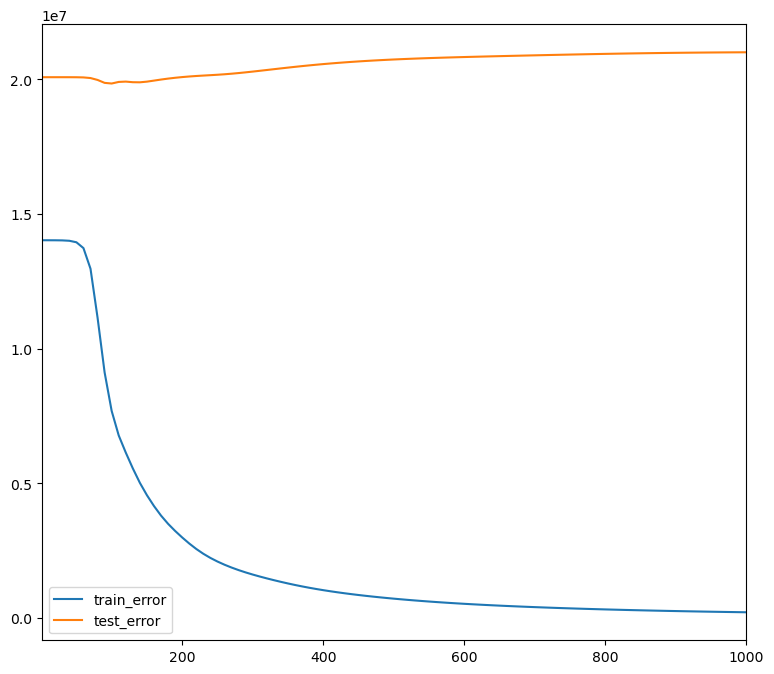

In [81]:
model = build_model(df_user_artist, embedding_dim=50, init_stddev=0.25)
model.train(num_iterations=1000, learning_rate=0.01)


##### Model evaluations
- From the graph above, the model is definitely overfitting and it is not capturing the underlying patterns in the data.
- The test error increases while the train error decreases.

Let's take a look at the user recommendations below

In [82]:
user_recommendations(model, 'dot', UserId=int(my_user_id1))
user_recommendations(model, 'cosine', UserId=int(my_user_id1))

,dot score,ArtistId,Name,TopTag,AllTags
469,6000.488,469,Eminem,Rap,"[Hip-hop, Rap, Pop, Hip-hop, Rap, HipHop, Rap,..."
7594,5357.874,7594,Bushido,German,"[80s, Synthpop, German, Hiphop, German, German]"
695,4440.155,695,Shakira,Pop,"[SpecialsTo3mmey, Pop, Rock, Pop, Dance, Rock,..."
66,4334.703,66,Depeche Mode,Electronic,"[Electronic, Electronic, Industrial, NewWave, ..."
286,4249.982,286,Christina Aguilera,Pop,"[Pop, Legend, Electronic, Pop, Dance, FemaleVo..."
283,4035.331,283,Britney Spears,Pop,"[Pop, Dance, Pop, Dance, Rock, Alternative, Se..."


,cosine score,ArtistId,Name,TopTag,AllTags
323,0.919,323,Justin Timberlake,Pop,"[Pop, Legend, Pop, Pop, HipHop, Pop, Rnb, Pop,..."
693,0.873,693,Esmée Denters,Rnb,"[Rnb, Amazing, Rnb]"
9454,0.784,9454,Absolute Beginner,German,"[German, Hiphop]"
9445,0.769,9445,Pyranja,German,"[German, SeenLive]"
7594,0.765,7594,Bushido,German,"[80s, Synthpop, German, Hiphop, German, German]"
5132,0.762,5132,Falco,80s,"[NewWave, 80s, Pop, 80's, 80s, 80sPop, 80s, 80..."


##### Male Artists Recommendations
*Dot*

The top recommendations are very strange, as the preferences were Chris Brown, Justin Timberlake, David Guetta, Kanye West and Drake.
It is strange this user Britney Spears or Taylor Swift. This needs to be improved.

*Cosine*

The cosine scores are more appropriate. Jay Sean an Robin are two artists I also enjoy. However, I don't know who Tarkan is and Justin Timberlake is someone I already listen to.

In [83]:
user_recommendations(model, 'dot', UserId=int(my_user_id2))
user_recommendations(model, 'cosine', UserId=int(my_user_id2))

,dot score,ArtistId,Name,TopTag,AllTags
695,6078.900,695,Shakira,Pop,"[SpecialsTo3mmey, Pop, Rock, Pop, Dance, Rock,..."
283,4166.506,283,Britney Spears,Pop,"[Pop, Dance, Pop, Dance, Rock, Alternative, Se..."
2528,3570.116,2528,Wanessa,Pop,"[Pop, FemaleVocalists, Pop, Dance, PopDance, F..."
289,3485.721,289,Beyoncé,Rnb,"[Legend, Rnb, HipHop, Pop, Pop, Legend, Girls,..."
338,3159.124,338,Taylor Swift,FemaleVocalists,"[Pop, FemaleVocalists, Pop, Amazing, Awesome, ..."
286,2781.674,286,Christina Aguilera,Pop,"[Pop, Legend, Electronic, Pop, Dance, FemaleVo..."


,cosine score,ArtistId,Name,TopTag,AllTags
316,0.872,316,Ashanti,Rnb,"[FemaleVocalists, Rnb, HipHop, FemaleVocalist,..."
6257,0.868,6257,Robin Thicke,Rnb,"[SeenLive, Rnb, FemaleVocalist, 00s, American,..."
1587,0.859,1587,Christina Milian,Rnb,"[Rnb, Chillout, Amazing, Rnb, FemaleVocalists,..."
4609,0.858,4609,Teairra Mari,Hip-hop,"[Hip-hop, Rnb, Pop, Hip-hop, Rap, FemaleVocali..."
4592,0.858,4592,The-Dream,Rnb,"[Alternative, Hip-hop, Amazing, Rnb, Rnb]"
2763,0.857,2763,Lenny Kravitz,Rock,"[Pop, Funk, Rock, AlternativeRock, Rock, Rock,..."


##### Female Artist Recommendations 
*Dot*

These the user who listens to Beyoncé, Jennifer Lopez, Leona Lewis, Katy Perry and the Black Eyed Peas. The top recommendations are spot on. Shakira, Britney Spears and Taylor Swift are brilliant suggestions.

*Cosine*

This are not so good. The top artist Lee Ryan has a tag of sad which is the opposite of what the user likes. The user wants to see more uplifting music primary from women. Therefore, Christina Milian is good recommendation but she needs to be higher on the list.

##### Artist Neighbors
Below are neightbors of Kanye West. Lil Wayne is the best example here. Avril Lavigne is a bad recommendation because she produced a different style of pop music.

In [84]:
artist_neighbors(model)

Nearest neighbors of : Kanye West.
Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream


,dot score,Name,TopTag,AllTags
372,21492.125,Evanescence,Rock,"[Alternative, GothicRock, Rock, AlternativeRoc..."
83,17889.234,Lady Gaga,Pop,"[Pop, Electronic, Pop, Dance, Electronic, Pop,..."
45,16350.589,Duran Duran,80s,"[NewWave, 80s, NewWave, 80s, NewWave, SynthPop..."
505,16128.189,U2,Rock,"[Pop, Rock, Rock, Awesome, Rock, 80s, Rock, Ro..."
325,14392.098,Kanye West,Hip-hop,"[Hip-hop, Rap, Rnb, Rap, HipHop, Favorite, Rap..."
783,13090.000,Thalía,FemaleVocalists,"[Electronic, Pop, FemaleVocalist, FemaleVocali..."


##### Artist Embeddings
- The FanCount or popularity of an artist is slightly correlated with the embedding norm

In [85]:
artist_embedding_norm(model)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.HConcatChart(...)

##### t-SNE Embeddings

In [86]:
tsne_artist_embeddings(model)

Running t-SNE...


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.HConcatChart(...)

## Regularization Functions
- To regularize the model we will use a gravity function

### Gravity


In [87]:
def gravity(U, V):
    """Creates a gravity loss given two embedding matrices."""
    return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
        tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

### Build Regularized Model

In [88]:
def build_regularized_model(
    ratings,
    embedding_dim=3,
    regularization_coeff=0.1,
    gravity_coeff=1.0,
    init_stddev=0.1,
):
    """
    Args:
      ratings: the DataFrame of artist ratings.
      embedding_dim: The dimension of the embedding space.
      regularization_coeff: The regularization coefficient lambda.
      gravity_coeff: The gravity regularization coefficient lambda_g.
    Returns:
      A CFModel object that uses a regularized loss.
    """

    # Creating number of users and artists variables
    n_users, n_artists = (
        df_user_artist.UserId.nunique(),
        df_user_artist.ArtistId.nunique(),
    )

    # Split the ratings DataFrame into train and test.
    train_listens, test_listens = split_dataframe(ratings)

    # SparseTensor representation of the train and test datasets.
    A_train = build_listen_sparse_tensor(train_listens, n_users, n_artists)
    A_test = build_listen_sparse_tensor(test_listens, n_users, n_artists)
    U = tf.Variable(
        tf.random_normal([A_train.dense_shape[0], embedding_dim], stddev=init_stddev)
    )
    V = tf.Variable(
        tf.random_normal([A_train.dense_shape[1], embedding_dim], stddev=init_stddev)
    )

    error_train = sparse_mean_square_error(A_train, U, V)
    error_test = sparse_mean_square_error(A_test, U, V)
    gravity_loss = gravity_coeff * gravity(U, V)
    regularization_loss = regularization_coeff * (
        tf.reduce_sum(U * U) / U.shape[0].value
        + tf.reduce_sum(V * V) / V.shape[0].value
    )
    total_loss = error_train + regularization_loss + gravity_loss
    losses = {
        "train_error_observed": error_train,
        "test_error_observed": error_test,
    }
    loss_components = {
        "observed_loss": error_train,
        "regularization_loss": regularization_loss,
        "gravity_loss": gravity_loss,
    }
    embeddings = {"UserId": U, "ArtistId": V}

    return CFModel(embeddings, total_loss, [losses, loss_components])


## Running Regularization Model

 iteration 2000: train_error_observed=10200.655273, test_error_observed=14218981.000000, observed_loss=10200.655273, regularization_loss=676.088501, gravity_loss=120400.03906208

[{'train_error_observed': 10200.655, 'test_error_observed': 14218981.0},
 {'observed_loss': 10200.655,
  'regularization_loss': 676.0885,
  'gravity_loss': 120400.04}]

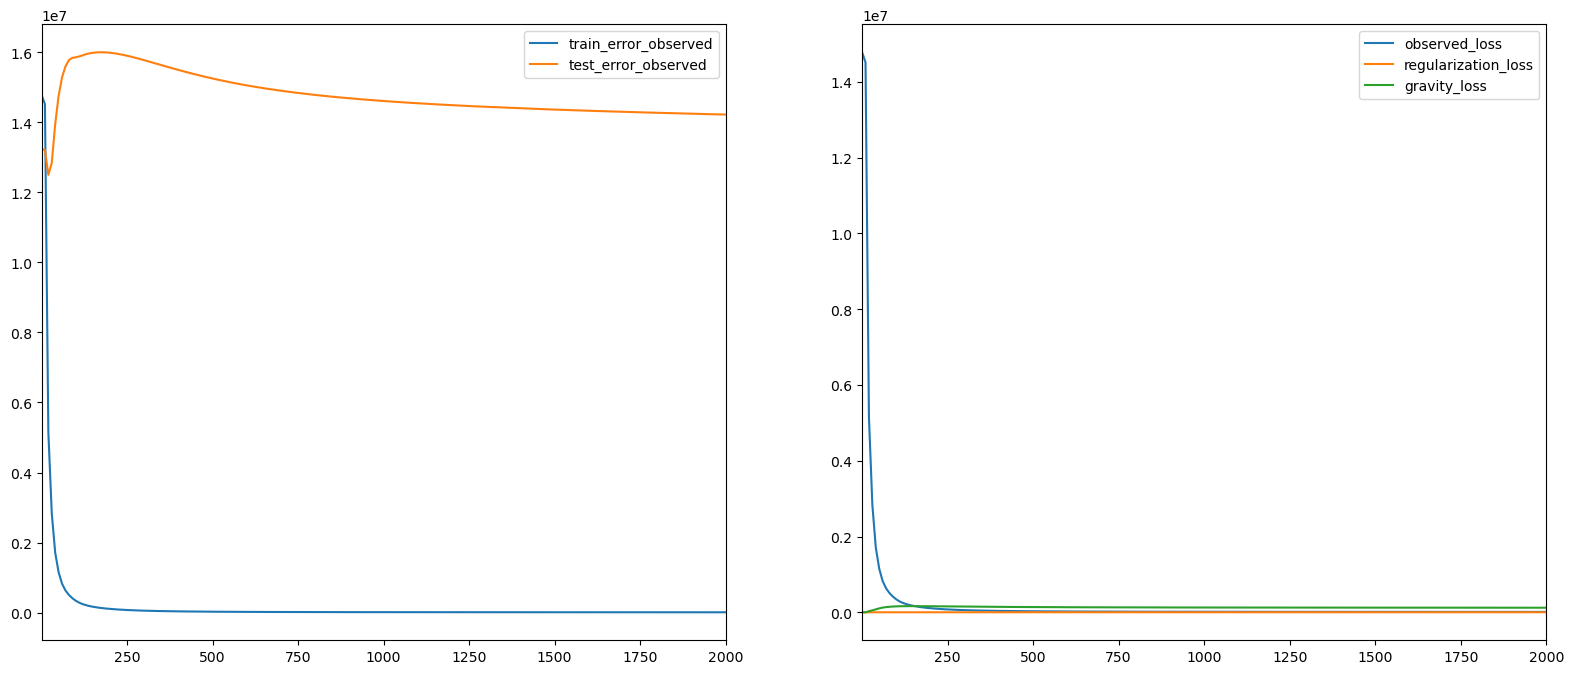

In [89]:
reg_model = build_regularized_model(
    df_user_artist, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=0.1)

##### Model Performance
- Despite introducing regularization the model is still clearly overfitting. This is exacerbated by more iterations.
- There needs to be a more effective approach to work with this data.

##### Male Artist Recommendations
*Dot*

- Justin Timberlake and Chris Brown are included here but they should be excluded.
- Eminem is a great recommendations as they coud expand the users interests from Drake and Kanye West.

*Cosine*
- These are poor recommendations except for Robin Thick which should be higher up

In [90]:
user_recommendations(reg_model, 'dot', UserId=int(my_user_id1))
user_recommendations(reg_model, 'cosine', UserId=int(my_user_id1))

,dot score,ArtistId,Name,TopTag,AllTags
197,8727.167,197,Blur,Rock,"[Alternative, Alternative, British, Alternativ..."
783,7066.646,783,Thalía,FemaleVocalists,"[Electronic, Pop, FemaleVocalist, FemaleVocali..."
288,6673.880,288,Leona Lewis,FemaleVocalists,"[Rnb, Pop, FemaleVocalists, Rnb, Pop, FemaleVo..."
2164,5749.309,2164,50 Cent,Rap,"[Hip-hop, Hip-hop, Rap, GangstaRap, Hip-hop, R..."
323,5732.716,323,Justin Timberlake,Pop,"[Pop, Legend, Pop, Pop, HipHop, Pop, Rnb, Pop,..."
505,5139.571,505,U2,Rock,"[Pop, Rock, Rock, Awesome, Rock, 80s, Rock, Ro..."


,cosine score,ArtistId,Name,TopTag,AllTags
321,0.812,321,Chris Brown,Rnb,"[Hip-hop, Rap, Rnb, Hip-hop, Rap, Rnb, HipHop,..."
323,0.767,323,Justin Timberlake,Pop,"[Pop, Legend, Pop, Pop, HipHop, Pop, Rnb, Pop,..."
15677,0.702,15677,Kate Hudson,FemaleVocalists,"[FemaleVocalists, FemaleVocalists]"
10320,0.653,10320,Mario,Rnb,"[Hip-hop, Rnb, Rnb, Hip-hop, Rap, Rnb, HipHop,..."
3281,0.649,3281,Trey Songz,Rnb,"[Rnb, Hip-hop, Amazing, Freestyle, HipHop, Hip..."
693,0.634,693,Esmée Denters,Rnb,"[Rnb, Amazing, Rnb]"


##### Female Artist Recommendations
*Dot*

- Once again Taylor Swift is a good choice however, the user already listens to Beyoncé and Leona Lewis. 
- My Chemical Romance is an interesting recommendation and perhaps could offer something different for the user.

*Cosine*

- These recommendations are incomprehensible.
- A more effective method must be found

In [91]:
user_recommendations(reg_model, 'dot', UserId=int(my_user_id2))
user_recommendations(reg_model, 'cosine', UserId=int(my_user_id2))

,dot score,ArtistId,Name,TopTag,AllTags
338,4521.132,338,Taylor Swift,FemaleVocalists,"[Pop, FemaleVocalists, Pop, Amazing, Awesome, ..."
288,2616.665,288,Leona Lewis,FemaleVocalists,"[Rnb, Pop, FemaleVocalists, Rnb, Pop, FemaleVo..."
197,2497.536,197,Blur,Rock,"[Alternative, Alternative, British, Alternativ..."
189,2437.046,189,Bright Eyes,Indie,"[IndieRock, Beautiful, Sad, Rock, Indie, Rock,..."
293,2392.578,293,Jennifer Lopez,Pop,"[Pop, Dance, Rnb, Pop, Dance, Rock, FemaleVoca..."
319,2017.697,319,Ashley Tisdale,Pop,"[Pop, Dance, Pop, FemaleVocalists, Awesome, Po..."


,cosine score,ArtistId,Name,TopTag,AllTags
293,0.814,293,Jennifer Lopez,Pop,"[Pop, Dance, Rnb, Pop, Dance, Rock, FemaleVoca..."
12797,0.769,12797,Teresa Salgueiro,,[]
12799,0.768,12799,Oz Bambaz,Brazil,[Brazil]
12795,0.768,12795,Parangolé,,[]
12796,0.767,12796,PSIRICO,,[]
12794,0.767,12794,Companhia do Calypso,,[]


##### Artist Neighbors
*Dot*

- Akon is an interesting recommendation as is known for Rap, Hip-Hop and Pop all similar tags for Kanye.
- Taylor Swift is not a good recommendation here.

*Cosine*

- Tinie Tempah is a fresh recommendation. Something I would really enjoy seeing considering my interests include Drake and Kanye West.
- Busta Rhymes is a very recommendation very similar to Kanye. 
- However, there are no similar recommendations for David Guetta.

In [92]:
artist_neighbors(reg_model, "Kanye", 'dot')
artist_neighbors(reg_model, "Kanye", 'cosine')

Nearest neighbors of : Kanye West.
Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream


,dot score,Name,TopTag,AllTags
1435,16497.564,Akon,Hip-hop,"[Pop, Hip-hop, Rnb, Rap, Rap, Rnb, HipHop, Pop..."
325,12757.730,Kanye West,Hip-hop,"[Hip-hop, Rap, Rnb, Rap, HipHop, Favorite, Rap..."
338,9553.946,Taylor Swift,FemaleVocalists,"[Pop, FemaleVocalists, Pop, Amazing, Awesome, ..."
521,9192.328,Lil' Wayne,Rap,"[Hip-hop, Rap, Hip-hop, HipHop, Hip-hop, Rap, ..."
293,9020.482,Jennifer Lopez,Pop,"[Pop, Dance, Rnb, Pop, Dance, Rock, FemaleVoca..."
2899,8357.791,Busta Rhymes,Hip-hop,"[HipHop, HipHop, Hip-hop, Rap, 00s, American, ..."


Nearest neighbors of : Kanye West.
Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream


,cosine score,Name,TopTag,AllTags
325,1.000,Kanye West,Hip-hop,"[Hip-hop, Rap, Rnb, Rap, HipHop, Favorite, Rap..."
17101,0.814,Andreea Banica,Pop,[Pop]
17097,0.814,After One,,[]
17105,0.814,Boyz N Da Hood,,[]
17104,0.814,Mr.Busta,,[]
17094,0.814,Kontrafakt,,[]


##### Artist Embeddings
- There appears to be no difference between the regularized model embeddings. In the top right corner we see Britney Spears, Lady Gaga, Christina Aguilera and Rihanna. These seems to be a female dominated data set.

In [93]:
artist_embedding_norm([reg_model])

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.HConcatChart(...)

##### t-SNE Embeddings
- The embeddings are all in an ellipse except for some outliers like britney spears. 
- On the top we have artists like pitbull, known for pop music, while on the bottom you have more Ray Lynch known for his new age instrumental music.

In [94]:
tsne_artist_embeddings(reg_model)

Running t-SNE...


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.HConcatChart(...)

## SoftMax Model Functions
- This section contains a number of functions used to build and develop the softmax model.

In [95]:
df_artists = df_artists.merge(
    df_user_artist[["UserId", "ArtistId"]]
    .groupby("ArtistId")["UserId"]
    .aggregate(lambda x: list(x)).rename('Listeners').reset_index(),
    left_on="ArtistId",
    right_on="ArtistId",
    how="left",
)


In [96]:
mean_dict = {
    artist: mean_listen_time for artist, mean_listen_time in zip(df_artists["ArtistId"], df_artists["MeanListenTime"])
}
tag_dict = {
    artist: tags
    for artist, tags in zip(df_artists["ArtistId"], df_artists["AllTags"])
}
user_dict = {
    artist: users
    for artist, users in zip(df_artists["ArtistId"], df_artists["Listeners"])
}

### Make Batch

In [97]:
def make_batch(df_user_artists, batch_size):
    """Creates a batch of examples.
    Args:
      df_user_artists: A DataFrame of ratings such that examples["ArtistId"] is a list of
        artists listened to by a user.
      batch_size: The batch size.
    """

    def pad(x, fill):
        return pd.DataFrame.from_dict(x).fillna(fill).values

    artist = []
    tag = []
    label = []
    for artist_ids in df_user_artists["ArtistId"].values:
        artist.append(artist_ids)
        tag.append([x for artist_id in artist_ids for x in tag_dict[artist_id]])
        label.append([int(artist_id) for artist_id in artist_ids])
        
    features = {
        "ArtistId": pad(artist, ""),
        "TopTag": pad(tag, ""),
        "Label": pad(label, -1),
    }
    batch = (
        tf.data.Dataset.from_tensor_slices(features)
        .shuffle(1000)
        .repeat()
        .batch(batch_size)
        .make_one_shot_iterator()
        .get_next()
    )
    return batch


### Select Random

In [98]:
def select_random(x):
    """Selectes a random elements from each row of x."""
    def to_float(x):
        return tf.cast(x, tf.float32)
    def to_int(x):
        return tf.cast(x, tf.int64)
    batch_size = tf.shape(x)[0]
    rn = tf.range(batch_size)
    nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
    rnd = tf.random_uniform([batch_size])
    ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
    return to_int(tf.gather_nd(x, ids))

### Softmax Loss

In [99]:
def softmax_loss(user_embeddings, artist_embeddings, labels):
    """Returns the cross-entropy loss of the softmax model.
    Args:
      user_embeddings: A tensor of shape [batch_size, embedding_dim].
      artist_embeddings: A tensor of shape [num_artists, embedding_dim].
      labels: A tensor of [batch_size], such that labels[i] is the target label
        for example i.
    Returns:
      The mean cross-entropy loss.
    """
    # Verify that the embddings have compatible dimensions
    user_emb_dim = user_embeddings.shape[1].value
    artist_emb_dim = artist_embeddings.shape[1].value
    if user_emb_dim != artist_emb_dim:
        raise ValueError(
            "The user embedding dimension %d should match the artist embedding "
            "dimension % d" % (user_emb_dim, artist_emb_dim)
        )

    logits = tf.matmul(user_embeddings, artist_embeddings, transpose_b=True)
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    )
    return loss


### Build Softmax Model

In [100]:
def build_softmax_model(df_user_artists, embedding_cols, hidden_dims):
    """Builds a Softmax model for LastFM data.
    Args:
      df_user_artists: DataFrame of training examples.
      embedding_cols: A dictionary mapping feature names (string) to embedding
        column objects. This will be used in tf.feature_column.input_layer() to
        create the input layer.
      hidden_dims: int list of the dimensions of the hidden layers.
    Returns:
      A CFModel object.
    """

    def create_network(features):
        """Maps input features dictionary to user embeddings.
        Args:
          features: A dictionary of input string tensors.
        Returns:
          outputs: A tensor of shape [batch_size, embedding_dim].
        """
        # Create a bag-of-words embedding for each sparse feature.
        inputs = tf.feature_column.input_layer(features, embedding_cols)

        # Hidden layers.
        input_dim = inputs.shape[1].value
        for i, output_dim in enumerate(hidden_dims):
            w = (
                tf.get_variable(
                    "hidden%d_w_" % i,
                    shape=[input_dim, output_dim],
                    initializer=tf.truncated_normal_initializer(
                        stddev=1.0 / np.sqrt(output_dim)
                    ),
                )
                / 10.0
            )
            outputs = tf.matmul(inputs, w)
            input_dim = output_dim
            inputs = outputs
        return outputs

    train_artists_grouped_user, test_artists_grouped_user = split_dataframe(df_user_artists)
    train_batch = make_batch(train_artists_grouped_user, 200)
    test_batch = make_batch(test_artists_grouped_user, 100)

    with tf.variable_scope("model", reuse=False):
        # Train
        train_user_embeddings = create_network(train_batch)
        train_labels = select_random(train_batch["Label"])
    with tf.variable_scope("model", reuse=True):
        # Test
        test_user_embeddings = create_network(test_batch)
        test_labels = select_random(test_batch["Label"])
        artist_embeddings = tf.get_variable(
            "input_layer/ArtistId_embedding/embedding_weights"
        )

    test_loss = softmax_loss(test_user_embeddings, artist_embeddings, test_labels)
    train_loss = softmax_loss(train_user_embeddings, artist_embeddings, train_labels)
    _, test_precision_at_10 = tf.metrics.precision_at_k(
        labels=test_labels,
        predictions=tf.matmul(
            test_user_embeddings, artist_embeddings, transpose_b=True
        ),
        k=10,
    )

    metrics = (
        {"train_loss": train_loss, "test_loss": test_loss},
        {"test_precision_at_10": test_precision_at_10},
    )
    embeddings = {"ArtistId": artist_embeddings}
    return CFModel(embeddings, train_loss, metrics)


### Make Embedding Col

In [101]:
def make_embedding_col(key, embedding_dim):
    if key =='MeanListenTime': t = 'int'
    else: t = 'str'
    categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=key, vocabulary_list=list(set(df_artists[key].astype(t).values)), num_oov_buckets=0
    )
    return tf.feature_column.embedding_column(
        categorical_column=categorical_col,
        dimension=embedding_dim,
        # default initializer: trancated normal with stddev=1/sqrt(dimension)
        combiner="mean",
    )

## Running Softmax Functions

 iteration 3000: train_loss=9.777168, test_loss=9.777109, test_precision_at_10=0.000085

({'train_loss': 9.777168, 'test_loss': 9.777109},
 {'test_precision_at_10': 8.530489836721093e-05})

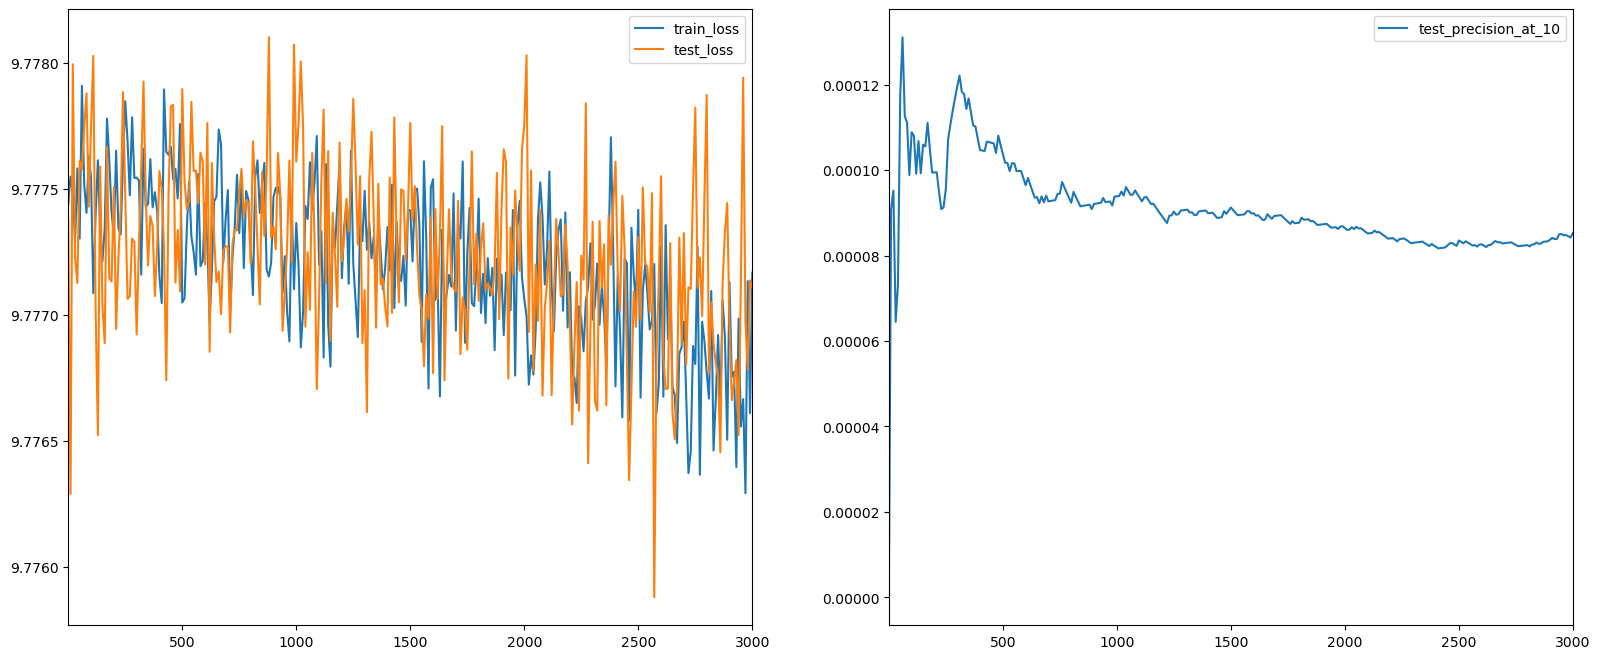

In [102]:
with tf.Graph().as_default():
    softmax_model = build_softmax_model(
        df_user_artists,
        embedding_cols=[
            make_embedding_col("ArtistId", 35),
            make_embedding_col("TopTag", 3),
        ],
        hidden_dims=[35],
    )

softmax_model.train(
    learning_rate=0.1, num_iterations=3000, optimizer=tf.train.AdagradOptimizer
)


##### Model Performance
- The softmax model has massively improved performance in comparison to the other two models
- The model also does not over fit which is a huge improvement. The test and train loss are very similar.
- The precision improves with each training iteration.

##### Artist Neighbors
- Unfortunately, the neighbors for Kanye West are no better for the softmax model.
- Hayden Panettiere is a really strange neighbor. She was once an actor in Heroes, a really cool tv show.

In [103]:
artist_neighbors(softmax_model, 'Kanye', 'dot')
artist_neighbors(softmax_model, 'Kanye', 'cosine')

Nearest neighbors of : Kanye West.
Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream


,dot score,Name,TopTag,AllTags
325,0.715,Kanye West,Hip-hop,"[Hip-hop, Rap, Rnb, Rap, HipHop, Favorite, Rap..."
9666,0.461,Fred Hammond & Radical for Christ,,[]
11264,0.460,Stan Getz,Jazz,"[Jazz, Jazz, Jazz, Jazz, Jazz, Chillout]"
16963,0.459,Amparanoia,World,[World]
9997,0.457,İclal Aydın,,[]
6913,0.456,"The ""K""",Uk,[Uk]


Nearest neighbors of : Kanye West.
Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream


,cosine score,Name,TopTag,AllTags
325,1.000,Kanye West,Hip-hop,"[Hip-hop, Rap, Rnb, Rap, HipHop, Favorite, Rap..."
16963,0.591,Amparanoia,World,[World]
16155,0.565,OBK,Pop,"[Pop, Synthpop]"
9997,0.564,İclal Aydın,,[]
6913,0.560,"The ""K""",Uk,[Uk]
10162,0.550,Peter Pan Speedrock,,[]


##### Softmax and Regularized Model Embedding Comparison
- There is a clear difference in the embeddings for both models
- Softmax has no correlation with FanCount
- This may shows the improvement in test performance

In [104]:
artist_embedding_norm([reg_model, softmax_model])

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.HConcatChart(...)

##### t-SNE Artist Embeddings
- The embeddings have formed a circle unfortunately, there is no separation or any visible clusters 
- At the bottom there are indie rock bands like the Walkmen and at the top there is classical music like Olufar Arnalds.

In [105]:
tsne_artist_embeddings(softmax_model)

Running t-SNE...


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.HConcatChart(...)

# Conclusions
In this notebook I have build three machine learning recommendation systems. I first built a basic model using tensor flow variables. Secondly I built a regularized model by applying a gravity function. Finally I built a softmax model. 

For each model I inspect the artist embeddings and neighbors. These embeddings were challenging to interpret however, when looking at specific examples, the embeddings allowed for separation of genres. An important factor in many of the models was popularity. Popularity strongly influenced the models embeddings except softmax.

I enabled a user to generate their own recommendations by adding their preferences to each model. This allowed a user to select how many recommendations they desire and what measure to use. When comparing measures, it seemed that dot product appeared to favour more popular artists.

The Softmax Model produced the best performance along with more independent embeddings.
I learned a lot about the libraries of tensorflow during this project. In the future, I will develop my knowledge around these packages and I will make improvements to the embeddings and recommendations generated resulting in better recommendations.